# Parameter Recovery

This notebook will cover a simulated parameter recovery of drift rate and discount factor according to avgWTP_left, avgWTP_right, and fixation, as known, trial level data. Generated data are based on:

- d = 0.002
- theta = 0.38
- noise = 0.018

However, all parameters are scaled to PyDDM's second basis instead of aDDM_toolbox's millisecond basis. The result is d increased by a factor of 1000, theta remaining the same, and noise being increased by a factor of sqrt 1000, yielding:

- d = 2
- theta = 0.38
- noise = 0.57

Using real data, we first generate "boxes" of data relating relative value and fixations. This will be used to randomly sample fixations for later.

In [1]:
import get_empirical_distributions

path = '/Users/braydenchien/Desktop/Enkavilab/DDM/1ms_trial_data.csv'
bin_size = 0.001
seed = 42

empirical_distributions = get_empirical_distributions.get_empirical_distributions(path, bin_size)

In [2]:
import numpy as np

def generate_fixations(bin_size, relative_value_difference):
    """
    Generates a fixation sequence binned in time using empirical distributions.
    For subsequent fixations (after the first), pools from both signs of 
    relative value difference. The first fixation remains sign-dependent.
    """
    probLeftFirst = empirical_distributions['probFixLeftFirst']
    left_first = np.random.rand() < probLeftFirst

    # Flip sign for matching fixation distribution to fixated side
    rel_val_for_first = relative_value_difference if left_first else -relative_value_difference

    events = []
    global_time = 0.0

    # Initial latency
    latency = np.random.choice(empirical_distributions['latencies'])
    events.append((global_time, global_time + latency, 0))
    global_time += latency

    # First fixation — sign-dependent
    first_fixation_duration = np.random.choice(
        empirical_distributions['fixations'][1][rel_val_for_first]
    )
    code = 1 if left_first else 2
    events.append((global_time, global_time + first_fixation_duration, code))
    global_time += first_fixation_duration

    # Prepare for alternation
    current_side_code = 2 if code == 1 else 1
    abs_val = abs(relative_value_difference)

    def pooled_fixation_durations(fixation_dict, abs_val):
        durations = []
        if abs_val in fixation_dict:
            durations.extend(fixation_dict[abs_val])
        if -abs_val in fixation_dict:
            durations.extend(fixation_dict[-abs_val])
        return durations

    # Subsequent fixations — pooled
    while global_time < 30.0:
        # Transition
        transition_duration = np.random.choice(empirical_distributions['transitions'])
        events.append((global_time, global_time + transition_duration, 0))
        global_time += transition_duration

        # Fixation from pooled durations
        next_durations = pooled_fixation_durations(empirical_distributions['fixations'][2], abs_val)
        next_fixation_duration = np.random.choice(next_durations)
        events.append((global_time, global_time + next_fixation_duration, current_side_code))
        global_time += next_fixation_duration

        # Alternate side
        current_side_code = 2 if current_side_code == 1 else 1

    # Bin into time steps
    num_bins = int(30 / bin_size)
    fixation_sequence = []

    for i in range(num_bins):
        bin_start_time = i * bin_size
        for start, end, event_code in events:
            if start <= bin_start_time < end:
                fixation_sequence.append(event_code)
                break
        else:
            fixation_sequence.append(0)

    return tuple(fixation_sequence)


We implemented a weighted sampling approach based on empirical distributions. This way, our simulated trials do not over-represent extreme relative value differences. There still is the issue of not being able to differentiate relative value differences of same magnitudes over different nominal values (eg. 1 and 3 and 2.4 and 4.5).6

Now we can generate data. Let's create a function to help with that. To randomly sample fixation data, it will randomly generate a pair of two numbers from 1 to 5 with 0.25 ticks from within fixation_dict's keys. Finally, it will randomly choose one of the fixation tuples associated with the inital randomly generated tuple.

In [3]:
import random

def create_trials(num_trials, seed=42):
    random.seed(seed)

    trials = list()
    for _ in range(num_trials):
        # Sample weights according to empirical weighted average of frequencies of that relative value difference
        # keys = [k for k in empirical_distributions['fixations'][1].keys()]
        # weights = [len(empirical_distributions['fixations'][1][k]) for k in keys]
        # sampled_key = float(random.choices(keys, weights=weights, k=1)[0])
        sampled_key = random.choice(np.linspace(-4, 4, 33))

        # Randomly generate a viable left value
        raw_max_left_value = ((5.0 - sampled_key) // 0.25) * 0.25
        max_left_value = min(5.0, raw_max_left_value)
        min_left_value = max(1.0, 1.0 - sampled_key)

        num_steps = int((max_left_value - min_left_value) / 0.25) + 1
        left_values = [round(min_left_value + i*0.25,2) for i in range(num_steps)]

        # Pick the left value
        left_value = random.choice(left_values)
        trials.append({'avgWTP_left': left_value, 'avgWTP_right': left_value + sampled_key, 'fixation': generate_fixations(0.001, sampled_key)})

    return trials

Now we can generate sample choices and RT's from trials we generated.

In [4]:
num_trials = 500
trials = create_trials(num_trials)

In [5]:
import pyddm
from pyddm.models import OverlayChain

def create_model(drift_rate, theta, noise):
    # Wrapper function to hyperparameterize drift_rate
    def make_drift_function(drift_rate):
        def drift_function(avgWTP_left, avgWTP_right, fixation, t):
            fixation_index = min(int(t/0.001), len(fixation)-1)
            current_fixation = fixation[fixation_index]
            if current_fixation == 0: # saccade
                return 0
            elif current_fixation == 1: # left
                return drift_rate * (avgWTP_left -  avgWTP_right * theta)
            else: # right
                return drift_rate * (avgWTP_left * theta -  avgWTP_right)
        
        return drift_function
    
    # Define the drift function
    my_drift_function = make_drift_function(drift_rate)

    # Define the model
    model = pyddm.gddm(
        drift=my_drift_function,
        noise=noise,
        bound=1,
        nondecision=0,
        conditions=["avgWTP_left", "avgWTP_right", "fixation"],
        choice_names=("left", "right"),
        T_dur=10,
        dx=0.001,
        dt=0.001
    )

    model._overlay = OverlayChain(overlays=[])
    return model

In [6]:
_drift_rate = 1.2
_theta = 0.38
_noise = 0.45
model = create_model(_drift_rate, _theta, _noise)

In [7]:
import pandas as pd
import os

def simulate(bin_size, model, trials, seed=42, save_results=True):
    results_df = list()

    random.seed(seed)

    for trial in trials:
        res = model.simulate_trial(trial)
        trial_fixation_tuple = trial['fixation'][:int(len(res)/(bin_size/model.dt))]
        trial_RT = round(len(trial_fixation_tuple)*bin_size, 3)
        if res[-1] >= 1:
            choice = 0
        elif res[-1] <= -1:
            choice = 1
        else:
            raise ValueError(f'Simulation ended before a decision was reached with last relative decision value of {res[-1]} but boundaries {model._bounddep.B} and {-1 * model._bounddep.B}. Please extend T_dur or modify parameters.')

        results_df.append({'trajectory': res, 'avgWTP_left': trial['avgWTP_left'], 'avgWTP_right': trial['avgWTP_right'], 'fixation': trial_fixation_tuple, 'RT': trial_RT, 'choice': choice})

    results_df = pd.DataFrame(results_df)
    if save_results:
        simulated_df = results_df[['choice', 'RT', 'avgWTP_left', 'avgWTP_right', 'fixation']]
        simulated_df.to_csv(os.path.join('simulated_data', f'sim_trials_{seed}_{_drift_rate}_{_theta}_{_noise}.csv'), index=False)
    return results_df

In [8]:
results_df = simulate(bin_size, model, trials)

In [9]:
def valid_simulation(results_df):
    good_trials = 0
    # Single-pass loop to count fixations
    def count_segments(data):
        count = 0
        in_segment = False

        for val in data:
            if val in (1, 2):
                if not in_segment:
                    count += 1
                    in_segment = True
            else:
                in_segment = False  # end the current segment

        return count

    for trial in results_df.itertuples():
        num_fixations = count_segments(trial.fixation)
        if num_fixations >= 2:
            good_trials += 1
    print(f'Number of trials with two or more fixations: {good_trials}')
    if good_trials >= 0.95 * len(results_df):
        return True
    else:
        return False

In [10]:
valid_simulation(results_df)

Number of trials with two or more fixations: 338


False

In [ ]:
import itertools

def grid_simulation():
    drift_rates = np.linspace(0.9, 1.3, 3)
    noise_levels = np.linspace(0.2, 0.6, 3)
    theta = 0.38

    for drift, noise in itertools.product(drift_rates, noise_levels):
        model = create_model(drift, theta, noise)
        try:
            results = simulate(bin_size, model, trials)
        except ValueError:
            print(f'Parameter combination drift rate: {drift}, noise: {noise} results in timeout')
            continue

        if valid_simulation(results):
            return results
        
good_result_df = grid_simulation()

In [29]:
_drift_rate = 0.75
_theta = 0.38
_noise = 0.35
model = create_model(_drift_rate, _theta, _noise)
results = simulate(bin_size, model, trials)
valid_simulation(results)

Number of trials with two or more fixations: 442


False

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(trial):
    """
    Plots the trajectory of the decision variable over time,
    shading periods of fixation left/right.

    Parameters:
    - trial: dict with keys:
        - 'trajectory': list or np.array of decision variable
        - 'fixation': list or np.array of fixation states (1=left, 2=right)
        - etc.
    """
    trajectory = np.array(trial['trajectory'])
    fixation = np.array(trial['fixation'])
    timesteps = np.arange(len(trajectory)) * model.dt

    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot trajectory line
    ax.plot(timesteps, trajectory, color="black", label="Trajectory")

    # Identify contiguous fixation segments
    current_state = fixation[0]
    start_idx = 0
    for i in range(1, len(fixation)):
        if fixation[i] != current_state or i == len(fixation) - 1:
            end_idx = i if fixation[i] != current_state else i + 1
            if current_state == 1:
                ax.axvspan(timesteps[start_idx], timesteps[end_idx - 1], color="blue", alpha=0.2, label="Fixation Left" if start_idx == 0 else "")
            elif current_state == 2:
                ax.axvspan(timesteps[start_idx], timesteps[end_idx - 1], color="red", alpha=0.2, label="Fixation Right" if start_idx == 0 else "")
            start_idx = i
            current_state = fixation[i]

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Decision Variable")
    ax.set_title("aDDM Accumulation Trajectory with Fixation Shading")
    ax.grid(True)

    # Avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

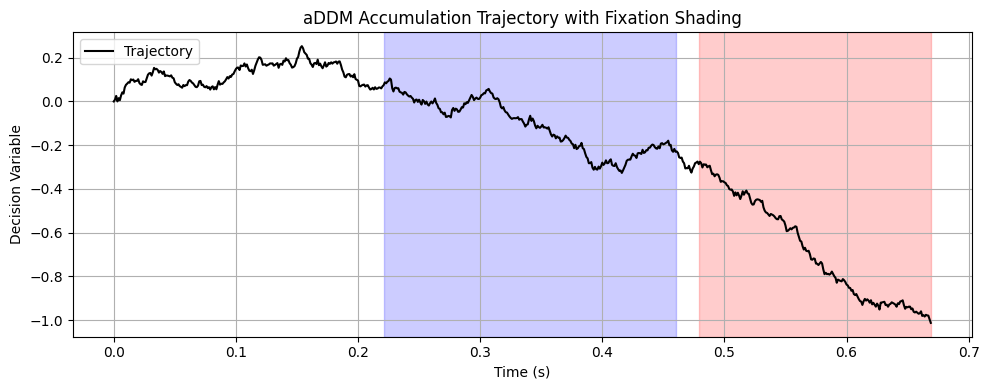

In [36]:
plot_trajectory(results.loc[5])